In [2]:
import os
from shutil import move

def organize_files(base_dir):
    """
    Organize audio and TextGrid files into subdirectories per speaker and session.
    Filename  'Speaker1_Argentina_Female_1_0.wav'
    """
    files = [f for f in os.listdir(base_dir) if f.endswith(('.wav', '.TextGrid'))]
    print(f"Found {len(files)} files to organize.")

    for file in files:
        
        parts = file.split('_')
        speaker_id = '_'.join(parts[:3])  
        session_id = parts[3].split('.')[0]  

        
        new_dir = os.path.join(base_dir, speaker_id, 'Session' + session_id)
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
            print(f"Created directory: {new_dir}")

        
        old_file_path = os.path.join(base_dir, file)
        new_file_path = os.path.join(new_dir, file)
        move(old_file_path, new_file_path)
        print(f"Moved {file} to {new_dir}")

def main():
    base_dir = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios'
    organize_files(base_dir)

if __name__ == "__main__":
    main()


Found 1406 files to organize.
Created directory: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker5_Africa_Male/Session1
Moved Speaker5_Africa_Male_1_23.wav to /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker5_Africa_Male/Session1
Created directory: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker8_France_Female/Session3
Moved Speaker8_France_Female_3_6.TextGrid to /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker8_France_Female/Session3
Created directory: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session3
Moved Speaker9_France_Male_3_22.wav to /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session3
Moved Speaker8_France_Female_3_7.TextGrid to /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker8_France_Female/Session3
Created directory: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker7_Russia_Female

In [9]:
import os
import parselmouth
import pandas as pd
import textgrid
import numpy as np

In [39]:
import os
import parselmouth
from parselmouth import PraatError
import pandas as pd
import textgrid
import numpy as np

def extract_pitch_per_word(audio_path, textgrid_path):
    sound = parselmouth.Sound(audio_path)
    grid = textgrid.TextGrid.fromFile(textgrid_path)
    
    word_tier = grid.getFirst("Words")
    pitches = []
    sentence_text = " ".join([word.mark.strip() for word in word_tier if word.mark.strip() and word.mark.strip() != '#'])
    
    initial_pitch_floor = 50
    pitch_ceiling = 600
    increment = 5  
    for word in word_tier:
        if word.mark.strip() and word.mark.strip() != '#':
            segment = sound.extract_part(from_time=word.minTime, to_time=word.maxTime, preserve_times=True)
            pitch_floor = initial_pitch_floor
            while True:
                try:
                    pitch = segment.to_pitch(pitch_floor=pitch_floor, pitch_ceiling=pitch_ceiling)
                    break
                except PraatError as e:
                    pitch_floor += increment
                    if pitch_floor >= pitch_ceiling:
                        print("Max pitch floor reached, estimating pitch.")
                        mean_pitch = estimate_pitch_from_context(pitches)  # Hypothetical function to estimate pitch
                        break

            if pitch_floor < pitch_ceiling:
                pitch_values = pitch.selected_array['frequency']
                mean_pitch = np.mean(pitch_values[pitch_values != 0]) if len(pitch_values[pitch_values != 0]) > 0 else 0

            pitches.append({
                'Sentence': sentence_text,
                'Word': word.mark,
                'Start_Time': word.minTime,
                'End_Time': word.maxTime,
                'Mean_F0': mean_pitch if mean_pitch else 'unreliable'
            })
    
    return pitches

def estimate_pitch_from_context(pitches):
    
    valid_pitches = [p['Mean_F0'] for p in pitches if p['Mean_F0'] != 'unreliable' and p['Mean_F0'] > 0]
    return np.mean(valid_pitches) if valid_pitches else 'unreliable'

def process_folder(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    textgrid_files = [f for f in os.listdir(folder_path) if f.endswith('.TextGrid')]
    all_data = []

    for audio_file, textgrid_file in zip(sorted(audio_files), sorted(textgrid_files)):
        audio_path = os.path.join(folder_path, audio_file)
        textgrid_path = os.path.join(folder_path, textgrid_file)
        data = extract_pitch_per_word(audio_path, textgrid_path)
        all_data.extend(data)

    df = pd.DataFrame(all_data)
    df.to_csv(os.path.join(folder_path, 'f0_data.csv'), index=False)
    print(f"F0 data saved to {os.path.join(folder_path, 'f0_data.csv')}")

if __name__ == "__main__":
    folder_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1'
    process_folder(folder_path)


F0 data saved to /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/f0_data.csv


In [41]:
import os
import pandas as pd

def extract_metadata_from_filename(filename):
    """
    Extracts metadata from the given filename.
    Filename format: 'SpeakerID_Country_Gender_Age_f0_data.csv'
    """
    parts = filename.split('_')
    speaker_id = parts[0]
    country = parts[1]
    gender = parts[2]
    age = parts[3] 
    age = ''.join(filter(str.isdigit, age))  
    return {
        'SpeakerID': speaker_id,
        'Country': country,
        'Gender': gender,
        'Age': age
    }

def combine_f0_data(base_directory):
    all_data_frames = []
    for root, dirs, files in os.walk(base_directory):
        for file in files:
            if file.endswith('f0_data.csv'):
                file_path = os.path.join(root, file)
                print("Attempting to read from:", file_path)
                try:
                    df = pd.read_csv(file_path, encoding='utf-8-sig')  
                    if df.empty:
                        print(f"File is empty (no data): {file_path}")
                        continue
                    metadata = extract_metadata_from_filename(file)
                    for key, value in metadata.items():
                        df[key] = value  
                    all_data_frames.append(df)
                except pd.errors.EmptyDataError:
                    print(f"Empty data in file, skipped: {file_path}")
                except Exception as e:
                    print(f"An error occurred while reading {file_path}: {e}")

    if all_data_frames:
        combined_df = pd.concat(all_data_frames, ignore_index=True)
        combined_df.to_csv(os.path.join(base_directory, 'combined_f0_data_with_metadata.csv'), index=False)
        print(f"Combined F0 data with metadata saved to {os.path.join(base_directory, 'combined_f0_data_with_metadata.csv')}")
    else:
        print("No data to combine.")


base_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios'
combine_f0_data(base_directory)


Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/compiled_f0_data.csv
Empty data in file, skipped: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/compiled_f0_data.csv
Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker6_France_Female/Session1/Speaker6_France_Female_21_f0_data.csv
Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker5_Africa_Male/Session3/Speaker5_Ghana_Male_41_f0_data.csv
Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker4_France_Male/Session1/Speaker4_France_Male_22_f0_data.csv
Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker8_France_Female/Session1/Speaker8_France_Female_60_f0_data.csv
Attempting to read from: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker2_Spain_Male/Session1/Speaker2_Spain_Male_26_f0_data.csv
Attempting to rea

In [42]:
import pandas as pd


file_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/combined_f0_data_with_metadata.csv'
data = pd.read_csv(file_path)


unique_speakers = data['SpeakerID'].nunique()


sentence_counts = data.groupby('SpeakerID')['Sentence'].nunique()


print(f"Total number of unique speakers: {unique_speakers}")
print("Number of unique sentences per speaker:")
print(sentence_counts)


Total number of unique speakers: 9
Number of unique sentences per speaker:
SpeakerID
Speaker1    30
Speaker2    30
Speaker3    30
Speaker4    30
Speaker5    30
Speaker6    30
Speaker7    30
Speaker8    30
Speaker9    30
Name: Sentence, dtype: int64


In [74]:
import os
import pandas as pd
import textgrid
import crepe
from scipy.io import wavfile

def load_textgrid(textgrid_path):
    return textgrid.TextGrid.fromFile(textgrid_path)

def analyze_pitch_crepe(audio_path):
    sr, audio = wavfile.read(audio_path)
    time, frequency, confidence, activation = crepe.predict(audio, sr, viterbi=True)
    return pd.DataFrame({'Time': time, 'Frequency': frequency, 'Confidence': confidence})

def map_pitch_to_text(pitch_df, tg):
    word_tier = tg.getFirst('Words')
    sentence_text = " ".join([word.mark.strip() for word in word_tier if word.mark.strip() and word.mark.strip() != '#'])

    pitch_df['Word'] = ''
    pitch_df['Sentence'] = sentence_text
    pitch_df['Mean_F0'] = np.nan

    for word in word_tier:
        if word.mark.strip() and word.mark.strip() != '#':
            mask = (pitch_df['Time'] >= word.minTime) & (pitch_df['Time'] <= word.maxTime)
            pitch_df.loc[mask, 'Word'] = word.mark
            mean_f0 = pitch_df.loc[mask, 'Frequency'].mean()
            pitch_df.loc[mask, 'Mean_F0'] = mean_f0 if not pd.isna(mean_f0) else 'unreliable'

    return pitch_df[pitch_df['Word'] != '']

def process_audio_with_textgrid(audio_path, textgrid_path):
    pitch_data = analyze_pitch_crepe(audio_path)
    tg = load_textgrid(textgrid_path)
    return map_pitch_to_text(pitch_data, tg)

def process_speaker(directory):
    results = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            audio_path = os.path.join(directory, file)
            textgrid_path = audio_path.replace('.wav', '.TextGrid')

            print(f"Processing: {audio_path}")
            processed_data = process_audio_with_textgrid(audio_path, textgrid_path)
            results.append(processed_data)

    
    if results:
        combined_df = pd.concat(results, ignore_index=True)
        combined_df.to_csv(os.path.join(directory, 'complete_pitch_analysis.csv'), index=False)
        print(f"Results saved to {os.path.join(directory, 'complete_pitch_analysis.csv')}")


speaker_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1'  # Adjust the path to your specific speaker's directory
process_speaker(speaker_directory)



Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_27.wav
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_26.wav
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 952ms/step
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_18.wav
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 975ms/step
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_24.wav
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 965ms/step
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_25.wav
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 918ms/step
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_19.wav
6/6 ━━━━━━

In [77]:
import os
import pandas as pd


def parse_metadata(file_path):
   
    base_name = os.path.basename(file_path)  
    parts = base_name.split('_')  
    
    speaker = parts[0]
    country = parts[1]
    gender = parts[2]
    age = int(parts[3])
    
    return speaker, country, gender, age


def load_and_combine_csv(file_paths):
    combined_df = pd.DataFrame()
    
    for file_path in file_paths:
        
        speaker, country, gender, age = parse_metadata(file_path)
        
       
        df = pd.read_csv(file_path)
        
        
        df['Speaker'] = speaker
        df['Country'] = country
        df['Gender'] = gender
        df['Age'] = age
        
       
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df


file_paths = [
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker1_Argentina_Female/Session1/Speaker1_Argentina_Female_27_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker2_Spain_Male/Session1/Speaker2_Spain_Male_26_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker3_France_Male/Session2/Speaker3_France_Male_23_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker4_France_Male/Session1/Speaker4_France_Male_22_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker5_Africa_Male/Session3/Speaker5_Ghana_Male_41_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker6_France_Female/Session1/Speaker6_France_Female_21_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker7_Russia_Female/Session3/Speaker7_Russia_Female_32_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker8_France_Female/Session1/Speaker8_France_Female_60_f0_CREPE.csv',
    '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_30_f0_CREPE.csv',
]

combined_df = load_and_combine_csv(file_paths)

combined_df.to_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/combined_speech_data.csv', index=False)

combined_df


,Time,Frequency,Confidence,Word,Sentence,Mean_F0,Speaker,Country,Gender,Age
0,0.25,254.649910,0.016032,Je,Je suis impressionnée par ta progression.,251.445596,Speaker1,Argentina,Female,27
1,0.26,265.911625,0.044889,Je,Je suis impressionnée par ta progression.,251.445596,Speaker1,Argentina,Female,27
2,0.27,274.285921,0.370463,Je,Je suis impressionnée par ta progression.,251.445596,Speaker1,Argentina,Female,27
3,0.28,247.588747,0.499385,Je,Je suis impressionnée par ta progression.,251.445596,Speaker1,Argentina,Female,27
4,0.29,247.090284,0.674713,Je,Je suis impressionnée par ta progression.,251.445596,Speaker1,Argentina,Female,27
...,...,...,...,...,...,...,...,...,...,...
45170,1.45,148.883295,0.020732,musique?,Tu écoutes quoi comme musique?,107.427091,Speaker9,France,Male,30
45171,1.46,158.838054,0.022082,musique?,Tu écoutes quoi comme musique?,107.427091,Speaker9,France,Male,30
45172,1.47,179.647438,0.036163,musique?,Tu écoutes quoi comme musique?,107.427091,Speaker9,France,Male,30
45173,1.48,199.683526,0.002603,musique?,Tu écoutes quoi comme musique?,107.427091,Speaker9,France,Male,30


In [81]:
unique_speakers = combined_df['Speaker'].nunique()
print(f"Number of unique speakers: {unique_speakers}")

Number of unique speakers: 9


In [82]:
sentences_per_speaker = combined_df.groupby('Speaker')['Sentence'].nunique()
print("Number of unique sentences per speaker:")
print(sentences_per_speaker)

Number of unique sentences per speaker:
Speaker
Speaker1    30
Speaker2    30
Speaker3    30
Speaker4    30
Speaker5    30
Speaker6    30
Speaker7    30
Speaker8    30
Speaker9    30
Name: Sentence, dtype: int64


In [98]:
import pandas as pd

# Load the datasets
crepe_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/CREPE_f0_data.csv'
praat_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Praat_f0_data.csv'

crepe_df = pd.read_csv(crepe_data_path)
praat_df = pd.read_csv(praat_data_path)

# Display the first few rows of each dataset
crepe_df_head = crepe_df.head()
praat_df_head = praat_df.head()

crepe_df_head, praat_df_head


(   Time   Frequency  Confidence Word  \
 0  0.25  254.649910    0.016032   Je   
 1  0.26  265.911625    0.044889   Je   
 2  0.27  274.285921    0.370463   Je   
 3  0.28  247.588747    0.499385   Je   
 4  0.29  247.090284    0.674713   Je   
 
                                     Sentence     Mean_F0   Speaker    Country  \
 0  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
 1  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
 2  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
 3  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
 4  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
 
    Gender  Age  
 0  Female   27  
 1  Female   27  
 2  Female   27  
 3  Female   27  
 4  Female   27  ,
                                             Sentence       Word  Start_Time  \
 0  Il travaille en France, mais il n'est pas fran...         Il     

Feature_extraction

In [101]:
import numpy as np
import pandas as pd


def clean_mean_f0(df):
    df['Mean_F0'] = pd.to_numeric(df['Mean_F0'], errors='coerce')
    df.dropna(subset=['Mean_F0'], inplace=True)
    return df


def extract_features(df):
    df = clean_mean_f0(df)
    feature_list = []

    grouped = df.groupby(['Sentence', 'Speaker', 'Country']) if 'Speaker' in df.columns else df.groupby(['Sentence', 'SpeakerID', 'Country'])

    for name, group in grouped:
        sentence = name[0]
        speaker = name[1]
        country = name[2]

        
        mean_f0 = group['Mean_F0'].mean()
        median_f0 = group['Mean_F0'].median()
        variance_f0 = group['Mean_F0'].var()
        f0_range = group['Mean_F0'].max() - group['Mean_F0'].min()
        f0_std = group['Mean_F0'].std()
        f0_mad = (group['Mean_F0'] - group['Mean_F0'].mean()).abs().mean()
        skewness_f0 = group['Mean_F0'].skew()
        kurtosis_f0 = group['Mean_F0'].kurtosis()

        
        f0_diff = np.diff(group['Mean_F0'])
        rising_f0 = np.sum(f0_diff > 0)
        falling_f0 = np.sum(f0_diff < 0)
        flat_f0 = np.sum(f0_diff == 0)

        
        duration = group['End_Time'].max() - group['Start_Time'].min() if 'End_Time' in group.columns else group['Time'].max() - group['Time'].min()

        features = {
            'Sentence': sentence,
            'Speaker': speaker,
            'Country': country,
            'Mean_F0': mean_f0,
            'Median_F0': median_f0,
            'Variance_F0': variance_f0,
            'F0_Range': f0_range,
            'F0_Std': f0_std,
            'F0_MAD': f0_mad,
            'Skewness_F0': skewness_f0,
            'Kurtosis_F0': kurtosis_f0,
            'Rising_F0': rising_f0,
            'Falling_F0': falling_f0,
            'Flat_F0': flat_f0,
            'Duration': duration
        }

        feature_list.append(features)

    feature_df = pd.DataFrame(feature_list)
    return feature_df


crepe_features_df = extract_features(crepe_df)
praat_features_df = extract_features(praat_df)


crepe_features_df.to_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/crepe_features_speech_data_enhanced.csv', index=False)
praat_features_df.to_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/praat_features_speech_data_enhanced.csv', index=False)


crepe_features_df.head(), praat_features_df.head()


(                  Sentence   Speaker    Country     Mean_F0   Median_F0  \
 0  C'est combien, le café?  Speaker1  Argentina  250.965264  255.867507   
 1  C'est combien, le café?  Speaker2      Spain  127.823783  119.639893   
 2  C'est combien, le café?  Speaker3     France  138.998844  148.587807   
 3  C'est combien, le café?  Speaker4     France  130.189772  142.217971   
 4  C'est combien, le café?  Speaker5      Ghana  154.409850  130.081499   
 
    Variance_F0   F0_Range     F0_Std     F0_MAD  Skewness_F0  Kurtosis_F0  \
 0   675.567677  82.900607  25.991685  20.175851    -0.921712     0.223464   
 1   104.175712  27.465757  10.206650   9.833459     0.149770    -1.736829   
 2   218.928746  40.150787  14.796241  14.152973    -0.134529    -1.751910   
 3   193.014947  29.984233  13.892982  13.364666    -0.361937    -1.791037   
 4  1067.852030  71.238223  32.678005  30.355368     0.536126    -1.630438   
 
    Rising_F0  Falling_F0  Flat_F0  Duration  
 0          2           1

In [105]:
import pandas as pd
from sklearn.impute import SimpleImputer

def preprocess_features(features_df):
    
    numeric_cols = features_df.select_dtypes(include=['float64', 'int64']).columns
    non_numeric_cols = features_df.select_dtypes(exclude=['float64', 'int64']).columns
    
    
    imputer = SimpleImputer(strategy='mean')
    
    
    features_df[numeric_cols] = imputer.fit_transform(features_df[numeric_cols])
    
    return features_df


crepe_features_df_imputed = preprocess_features(crepe_features_df)
praat_features_df_imputed = preprocess_features(praat_features_df)

crepe_features_df_imputed.to_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/crepe_features_speech_data_imputed.csv', index=False)
praat_features_df_imputed.to_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/praat_features_speech_data_imputed.csv', index=False)


In [106]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Function to train and evaluate models with Grid Search
def train_and_evaluate_with_grid_search(features_df, model_path):
    # Split the data into features (X) and target (y)
    X = features_df.drop(columns=['Sentence', 'Speaker', 'Country', 'Mean_F0'])
    y = features_df['Mean_F0']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize a Random Forest Regressor
    regressor = RandomForestRegressor(random_state=42)

    # Initialize Grid Search
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

    # Fit Grid Search
    grid_search.fit(X_train, y_train)

    # Best parameters from Grid Search
    best_params = grid_search.best_params_
    print(f"Best parameters: {best_params}")

    # Predict on the test set using the best estimator
    best_regressor = grid_search.best_estimator_
    y_pred = best_regressor.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Save the trained model
    joblib.dump(best_regressor, model_path)

    return mse

# Train and evaluate models for CREPE and Praat datasets with Grid Search
crepe_mse = train_and_evaluate_with_grid_search(crepe_features_df_imputed, '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/crepe_f0_regressor_model_enhanced.pkl')
praat_mse = train_and_evaluate_with_grid_search(praat_features_df_imputed, '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/praat_f0_regressor_model_enhanced.pkl')

crepe_mse, praat_mse


Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 62.66000639222687
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error: 68.16602547667836


(62.66000639222687, 68.16602547667836)

FCN-F0

In [160]:
import os
import subprocess

def run_fcn_f0(audio_directory, output_directory, fcn_f0_script_path, model='993'):
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    python_path = '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3'  # Use the full path to the Python executable
    
    for audio_file in os.listdir(audio_directory):
        if audio_file.endswith('.wav'):
            input_path = os.path.join(audio_directory, audio_file)
            output_path = os.path.join(output_directory, audio_file.replace('.wav', f'.f0-{model}.csv'))
            command = [
                python_path, fcn_f0_script_path, input_path, 
                '-m', model, '-o', output_path
            ]
            subprocess.run(command)


audio_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1'
output_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output'
fcn_f0_script_path = '/Users/kiragrudinina/Desktop/Speech/FCNF0/FCN-f0/FCN-f0.py'
run_fcn_f0(audio_directory, output_directory, fcn_f0_script_path)


True


2024-05-14 10:51:23.729198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.8100226757369615
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_27.f0-993.csv
True


2024-05-14 10:51:41.144666: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.088979591836735
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_26.f0-993.csv
True


2024-05-14 10:51:56.022030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_18.f0-993.csv
True


2024-05-14 10:52:09.238517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.06
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 819ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_24.f0-993.csv
True


2024-05-14 10:52:21.338134: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.3099773242630386
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_25.f0-993.csv
True


2024-05-14 10:52:32.806428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.8550113378684807
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_19.f0-993.csv
True


2024-05-14 10:52:44.353178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.6100226757369616
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_21.f0-993.csv
True


2024-05-14 10:52:54.771841: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 3.6019954648526076
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_20.f0-993.csv
True


2024-05-14 10:53:05.086754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.0829931972789115
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_22.f0-993.csv
True


2024-05-14 10:53:15.771078: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 3.02
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_23.f0-993.csv
True


2024-05-14 10:53:26.000181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.7859863945578232
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_9.f0-993.csv
True


2024-05-14 10:53:36.291305: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.764988662131519
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_8.f0-993.csv
True


2024-05-14 10:53:46.931149: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 3.000997732426304
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_0.f0-993.csv
True


2024-05-14 10:53:57.770423: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.426984126984127
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 877ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_1.f0-993.csv
True


2024-05-14 10:54:08.004237: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_3.f0-993.csv
True


2024-05-14 10:54:18.631382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.3579591836734695
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_2.f0-993.csv
True


2024-05-14 10:54:28.792509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.7359637188208616
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_6.f0-993.csv
True


2024-05-14 10:54:39.381842: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.006984126984127
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_7.f0-993.csv
True


2024-05-14 10:54:49.655786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.5159637188208617
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_5.f0-993.csv
True


2024-05-14 10:54:59.491080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.6100226757369616
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_4.f0-993.csv
True


2024-05-14 10:55:09.951121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.886984126984127
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 791ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_12.f0-993.csv
True


2024-05-14 10:55:19.887482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.8520181405895693
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_13.f0-993.csv
True


2024-05-14 10:55:30.596162: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.7169614512471656
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 915ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_11.f0-993.csv
True


2024-05-14 10:55:41.006101: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.38
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_10.f0-993.csv
True


2024-05-14 10:55:51.947218: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.8239909297052153
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_14.f0-993.csv
True


2024-05-14 10:56:02.188265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.3769614512471655
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_28.f0-993.csv
True


2024-05-14 10:56:13.631043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.1449886621315193
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_29.f0-993.csv
True


2024-05-14 10:56:24.208525: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.245986394557823
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_15.f0-993.csv
True


2024-05-14 10:56:35.475231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 2.6249886621315195
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_17.f0-993.csv
True


2024-05-14 10:56:46.846909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


duration of sound is 1.74
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Saved the estimated frequencies values at /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_16.f0-993.csv


In [161]:
import os
import pandas as pd
import textgrid

def load_textgrid(textgrid_path):
    tg = textgrid.TextGrid.fromFile(textgrid_path)
    print(f"Loaded TextGrid from {textgrid_path}")
    return tg

def load_f0_data(f0_path):
    try:
        f0_data = pd.read_csv(f0_path, delim_whitespace=True, names=['Time', 'Frequency', 'Confidence'])
        f0_data['Time'] = pd.to_numeric(f0_data['Time'], errors='coerce')  # Ensure 'Time' is numeric
        print(f"Loaded F0 data from {f0_path}")
        print(f0_data.head())
        return f0_data
    except Exception as e:
        print(f"Error loading F0 data from {f0_path}: {e}")
        return pd.DataFrame(columns=['Time', 'Frequency', 'Confidence'])

def map_pitch_to_text(pitch_df, tg):
    word_tier = tg.getFirst('Words')
    sentence_text = " ".join([word.mark.strip() for word in word_tier if word.mark.strip() and word.mark.strip() != '#'])
    print(f"Extracted sentence: {sentence_text}")

    pitch_df['Word'] = ''
    pitch_df['Sentence'] = sentence_text
    pitch_df['Mean_F0'] = pd.NA

    for word in word_tier:
        if word.mark.strip() and word.mark.strip() != '#':
            print(f"Processing word: {word.mark}")
            mask = (pitch_df['Time'] >= word.minTime) & (pitch_df['Time'] <= word.maxTime)
            if mask.any():
                pitch_df.loc[mask, 'Word'] = word.mark
                mean_f0 = pitch_df.loc[mask, 'Frequency'].mean()
                pitch_df.loc[mask, 'Mean_F0'] = mean_f0 if not pd.isna(mean_f0) else 'unreliable'

    return pitch_df[pitch_df['Word'] != '']

def process_audio_with_textgrid(audio_path, textgrid_path, f0_path):
    pitch_data = load_f0_data(f0_path)
    tg = load_textgrid(textgrid_path)
    if pitch_data.empty:
        print(f"No valid pitch data for {audio_path}")
        return pd.DataFrame(columns=['Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0'])
    return map_pitch_to_text(pitch_data, tg)

def process_speaker(directory, f0_output_dir):
    results = []
    for file in os.listdir(directory):
        if file.endswith('.wav'):
            audio_path = os.path.join(directory, file)
            textgrid_path = audio_path.replace('.wav', '.TextGrid')
            f0_path = os.path.join(f0_output_dir, os.path.basename(audio_path).replace('.wav', '.f0-993.csv'))

            print(f"Processing: {audio_path}")
            processed_data = process_audio_with_textgrid(audio_path, textgrid_path, f0_path)
            results.append(processed_data)

    
    if results:
        combined_df = pd.concat(results, ignore_index=True)
        combined_df.to_csv(os.path.join(directory, 'complete_pitch_analysis.csv'), index=False)
        print(f"Results saved to {os.path.join(directory, 'complete_pitch_analysis.csv')}")
    else:
        print("No data processed.")


audio_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1'
f0_output_directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output'
process_speaker(audio_directory, f0_output_directory)




Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_27.wav
Loaded F0 data from /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Session1_output/Speaker9_France_Male_1_27.f0-993.csv
    Time  Frequency  Confidence
0  0.000    239.777       0.104
1  0.001    239.685       0.092
2  0.002    239.627       0.083
3  0.003    239.689       0.078
4  0.004    208.381       0.072
Loaded TextGrid from /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_27.TextGrid
Extracted sentence: On se retrouve à 20 heures, d'accord?
Processing word: On
Processing word: se
Processing word: retrouve
Processing word: à
Processing word: 20
Processing word: heures,
Processing word: d'accord?
Processing: /Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Speaker9_France_Male/Session1/Speaker9_France_Male_1_26.wav
Loaded F0 data f

In [162]:
import os
import pandas as pd

def parse_metadata(file_path):
    
    base_name = os.path.basename(file_path)
    
    parts = base_name.split('_')
    
    speaker = parts[0]
    country = parts[1]
    gender = parts[2]
    age = int(parts[3])
    
    return speaker, country, gender, age

def load_and_combine_csv(directory):
    combined_df = pd.DataFrame()
    
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('_f0_FCN993.csv'):
                file_path = os.path.join(root, file)
                
                
                speaker, country, gender, age = parse_metadata(file_path)
                
                
                df = pd.read_csv(file_path)
                
                
                df['Speaker'] = speaker
                df['Country'] = country
                df['Gender'] = gender
                df['Age'] = age
                
                
                combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df


directory = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios'  # Replace with your actual directory path
combined_df = load_and_combine_csv(directory)


output_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/combined_speech_data.csv'  # Replace with your desired output path
combined_df.to_csv(output_path, index=False)

#
print(combined_df.head())



    Time  Frequency  Confidence Word  \
0  0.250    297.991       0.088   Je   
1  0.251    297.821       0.096   Je   
2  0.252    597.681       0.102   Je   
3  0.253    595.205       0.126   Je   
4  0.254    597.243       0.126   Je   

                                       Sentence     Mean_F0   Speaker Country  \
0  Je suis français et je viens de la Bretagne.  272.996446  Speaker6  France   
1  Je suis français et je viens de la Bretagne.  272.996446  Speaker6  France   
2  Je suis français et je viens de la Bretagne.  272.996446  Speaker6  France   
3  Je suis français et je viens de la Bretagne.  272.996446  Speaker6  France   
4  Je suis français et je viens de la Bretagne.  272.996446  Speaker6  France   

   Gender  Age  
0  Female   21  
1  Female   21  
2  Female   21  
3  Female   21  
4  Female   21  


In [163]:
pd.read_csv("/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/FCN_fo_data.csv")

,Time,Frequency,Confidence,Word,Sentence,Mean_F0,Speaker,Country,Gender,Age
0,0.250,297.991,0.088,Je,Je suis français et je viens de la Bretagne.,272.996446,Speaker6,France,Female,21
1,0.251,297.821,0.096,Je,Je suis français et je viens de la Bretagne.,272.996446,Speaker6,France,Female,21
2,0.252,597.681,0.102,Je,Je suis français et je viens de la Bretagne.,272.996446,Speaker6,France,Female,21
3,0.253,595.205,0.126,Je,Je suis français et je viens de la Bretagne.,272.996446,Speaker6,France,Female,21
4,0.254,597.243,0.126,Je,Je suis français et je viens de la Bretagne.,272.996446,Speaker6,France,Female,21
...,...,...,...,...,...,...,...,...,...,...
448986,1.793,106.962,0.227,temps.,Imagine si on pouvait voyager dans ce temps.,111.302826,Speaker3,France,Male,23
448987,1.794,107.531,0.237,temps.,Imagine si on pouvait voyager dans ce temps.,111.302826,Speaker3,France,Male,23
448988,1.795,107.694,0.306,temps.,Imagine si on pouvait voyager dans ce temps.,111.302826,Speaker3,France,Male,23
448989,1.796,107.737,0.285,temps.,Imagine si on pouvait voyager dans ce temps.,111.302826,Speaker3,France,Male,23


In [164]:
def read_file_content(file_path, num_lines=10):
    try:
        with open(file_path, 'r') as file:
            lines = []
            for _ in range(num_lines):
                line = file.readline().strip()
                lines.append(line)
        return lines
    except Exception as e:
        return [f"Error reading file: {e}"]

crepe_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/CREPE_f0_data.csv'
fcn_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/FCN_fo_data.csv'
praat_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Praat_f0_data.csv'

crepe_content = read_file_content(crepe_data_path)
fcn_content = read_file_content(fcn_data_path)
praat_content = read_file_content(praat_data_path)

crepe_content, fcn_content, praat_content


(['Time,Frequency,Confidence,Word,Sentence,Mean_F0,Speaker,Country,Gender,Age',
  '0.25,254.6499097160452,0.0160319,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.26,265.9116253753528,0.044889152,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.27,274.2859206433014,0.37046275,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.28,247.5887466636364,0.49938542,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.29,247.09028405931195,0.6747129,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.3,246.4393398272644,0.827803,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',
  '0.31,246.98234422408444,0.8986549,Je,Je suis impressionnée par ta progression.,251.44559579938803,Speaker1,Argentina,Female,27',

CREPE Data:
   Time   Frequency  Confidence Word  \
0  0.25  254.649910    0.016032   Je   
1  0.26  265.911625    0.044889   Je   
2  0.27  274.285921    0.370463   Je   
3  0.28  247.588747    0.499385   Je   
4  0.29  247.090284    0.674713   Je   

                                    Sentence     Mean_F0   Speaker    Country  \
0  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
1  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
2  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
3  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   
4  Je suis impressionnée par ta progression.  251.445596  Speaker1  Argentina   

   Gender  Age  
0  Female   27  
1  Female   27  
2  Female   27  
3  Female   27  
4  Female   27  

FCN Data:
    Time  Frequency  Confidence Word  \
0  0.250    297.991       0.088   Je   
1  0.251    297.821       0.096   Je   
2  0.252    597.681       0

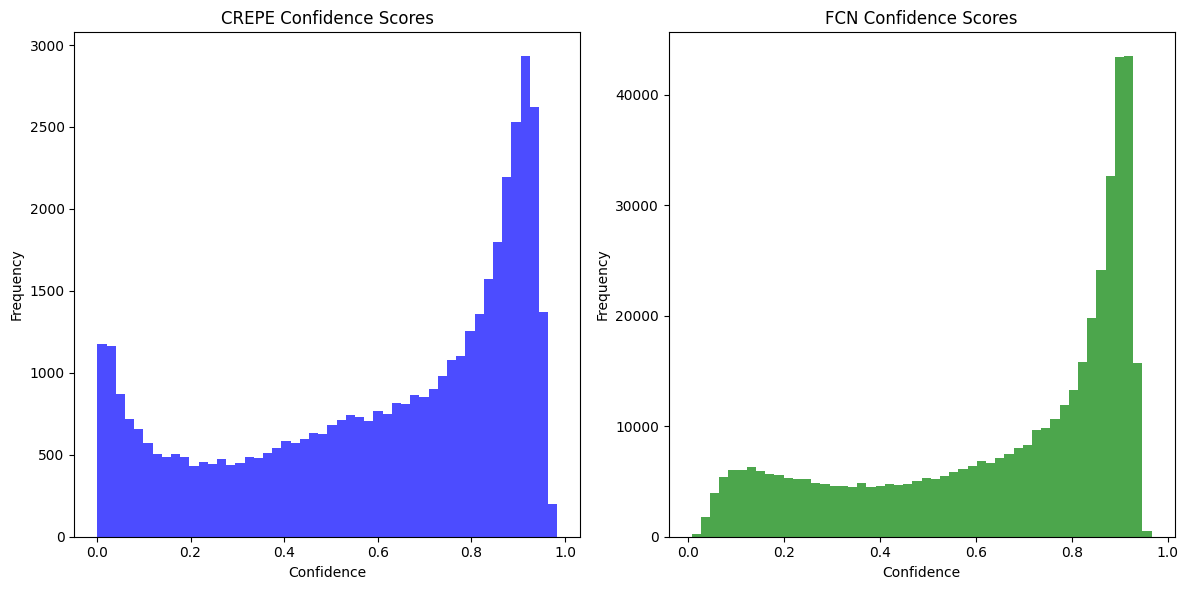

CREPE Mean Confidence: 0.603112818479896
FCN Mean Confidence: 0.6558950157130096


In [168]:
import pandas as pd
import matplotlib.pyplot as plt


crepe_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/CREPE_f0_data.csv'
fcn_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/FCN_fo_data.csv'
praat_data_path = '/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/Praat_f0_data.csv'

crepe_df = pd.read_csv(crepe_data_path)
fcn_df = pd.read_csv(fcn_data_path)
praat_df = pd.read_csv(praat_data_path)

praat_df.rename(columns={'Start_Time': 'Time', 'SpeakerID': 'Speaker'}, inplace=True)

# Add a dummy Confidence column to Praat data
praat_df['Confidence'] = 1.0

praat_df['Frequency'] = praat_df['Mean_F0']

crepe_df = crepe_df[['Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0', 'Speaker', 'Country', 'Gender', 'Age']]
fcn_df = fcn_df[['Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0', 'Speaker', 'Country', 'Gender', 'Age']]
praat_df = praat_df[['Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0', 'Speaker', 'Country', 'Gender', 'Age']]

print("CREPE Data:")
print(crepe_df.head())
print("\nFCN Data:")
print(fcn_df.head())
print("\nPraat Data:")
print(praat_df.head())

crepe_confidence = crepe_df['Confidence']
fcn_confidence = fcn_df['Confidence']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(crepe_confidence, bins=50, color='blue', alpha=0.7)
plt.title('CREPE Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(fcn_confidence, bins=50, color='green', alpha=0.7)
plt.title('FCN Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Calculate and print mean confidence scores
crepe_mean_confidence = crepe_confidence.mean()
fcn_mean_confidence = fcn_confidence.mean()

print(f"CREPE Mean Confidence: {crepe_mean_confidence}")
print(f"FCN Mean Confidence: {fcn_mean_confidence}")



In [177]:
# Check column names for all DataFrames
print("CREPE DataFrame Columns:")
print(crepe_df.columns)
print("\nFCN DataFrame Columns:")
print(fcn_df.columns)
print("\nPraat DataFrame Columns:")
print(praat_df.columns)


CREPE DataFrame Columns:
Index(['time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0',
       'Speaker', 'Country', 'Gender', 'Age'],
      dtype='object')

FCN DataFrame Columns:
Index(['time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0',
       'Speaker', 'Country', 'Gender', 'Age'],
      dtype='object')

Praat DataFrame Columns:
Index(['Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0',
       'Speaker', 'Country', 'Gender', 'Age'],
      dtype='object')


In [183]:
crepe_stats = crepe_df['Frequency'].describe()
fcn_stats = fcn_df['Frequency'].describe()
# Remove 'unreliable' entries from Praat data
praat_cleaned_df = praat_df[praat_df['Mean_F0'] != 'unreliable']
praat_cleaned_df['Mean_F0'] = pd.to_numeric(praat_cleaned_df['Mean_F0'])

praat_cleaned_stats = praat_cleaned_df['Mean_F0'].describe()



print("CREPE Summary Statistics:")
print(crepe_stats)
print("\nFCN Summary Statistics:")
print(fcn_stats)
print("Praat Cleaned Summary Statistics:")
print(praat_cleaned_stats)


CREPE Summary Statistics:
count    45175.000000
mean       172.025862
std         63.251044
min         32.048089
25%        119.076599
50%        155.199663
75%        218.591758
max        987.331952
Name: Frequency, dtype: float64

FCN Summary Statistics:
count    448991.000000
mean        164.602838
std          75.142333
min          30.446000
25%         111.869000
50%         141.577000
75%         214.023000
max         932.647000
Name: Frequency, dtype: float64
Praat Cleaned Summary Statistics:
count    1838.000000
mean      172.043656
std        63.890762
min        53.175438
25%       117.629627
50%       152.761968
75%       222.537250
max       557.028399
Name: Mean_F0, dtype: float64


/var/folders/x_/mxyt8w111r9f0gxnb78_lw6c0000gn/T/ipykernel_48733/2418550346.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  praat_cleaned_df['Mean_F0'] = pd.to_numeric(praat_cleaned_df['Mean_F0'])


/var/folders/x_/mxyt8w111r9f0gxnb78_lw6c0000gn/T/ipykernel_48733/318525701.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crepe_sentence_df['Smoothed_Frequency'] = savgol_filter(crepe_sentence_df['Frequency'], window_length, polyorder)
/var/folders/x_/mxyt8w111r9f0gxnb78_lw6c0000gn/T/ipykernel_48733/318525701.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcn_sentence_df['Smoothed_Frequency'] = savgol_filter(fcn_sentence_df['Frequency'], window_length, polyorder)


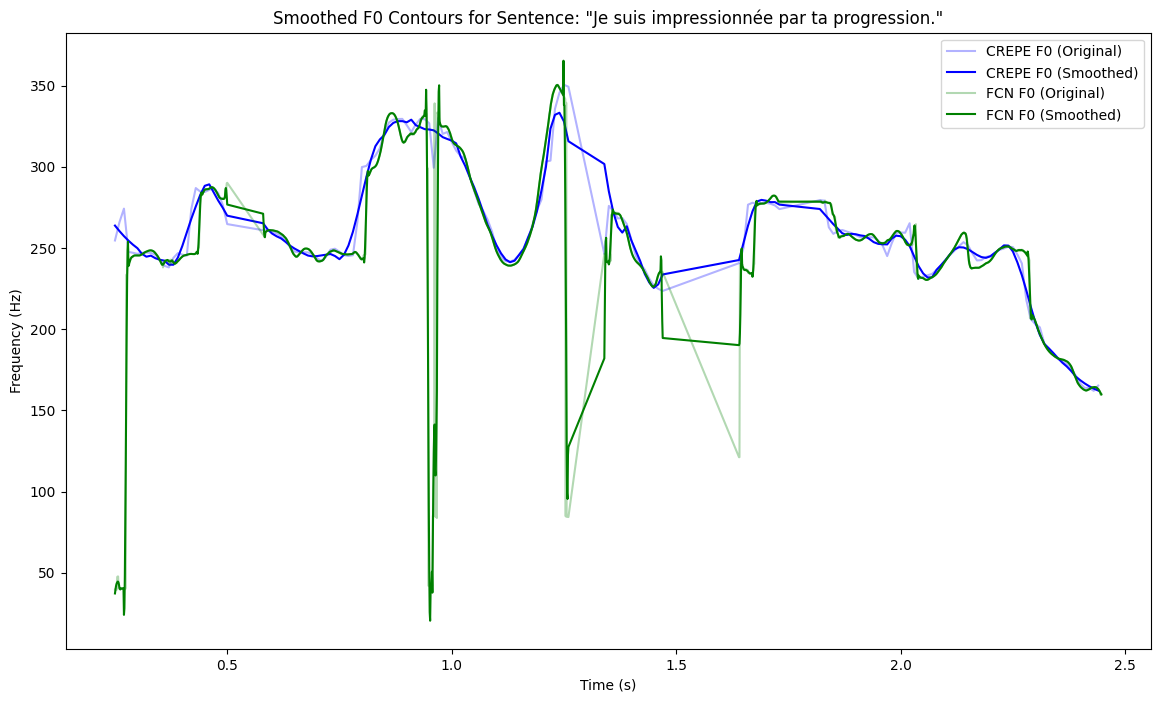

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter



sentence = "Je suis impressionnée par ta progression."
speaker = "Speaker1"

crepe_sentence_df = crepe_df[(crepe_df['Sentence'] == sentence) & (crepe_df['Speaker'] == speaker)]
fcn_sentence_df = fcn_df[(fcn_df['Sentence'] == sentence) & (fcn_df['Speaker'] == speaker)]

# Apply Savitzky-Golay filter to smooth the F0 contours
window_length = 11  # Choose an odd number
polyorder = 2

crepe_sentence_df['Smoothed_Frequency'] = savgol_filter(crepe_sentence_df['Frequency'], window_length, polyorder)
fcn_sentence_df['Smoothed_Frequency'] = savgol_filter(fcn_sentence_df['Frequency'], window_length, polyorder)

# Plot the results
plt.figure(figsize=(14, 8))

# Plot CREPE data
plt.plot(crepe_sentence_df['time'], crepe_sentence_df['Frequency'], label='CREPE F0 (Original)', alpha=0.3, color='blue')
plt.plot(crepe_sentence_df['time'], crepe_sentence_df['Smoothed_Frequency'], label='CREPE F0 (Smoothed)', color='blue')

# Plot FCN data
plt.plot(fcn_sentence_df['time'], fcn_sentence_df['Frequency'], label='FCN F0 (Original)', alpha=0.3, color='green')
plt.plot(fcn_sentence_df['time'], fcn_sentence_df['Smoothed_Frequency'], label='FCN F0 (Smoothed)', color='green')

plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(f'Smoothed F0 Contours for Sentence: "{sentence}"')
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def apply_savgol_filter(df, window_length=11, polyorder=2):
    df['Smoothed_Frequency'] = savgol_filter(df['Frequency'], window_length, polyorder)
    return df

def plot_f0_contours(crepe_df, fcn_df, sentence, speaker):
    crepe_sentence_df = crepe_df[(crepe_df['Sentence'] == sentence) & (crepe_df['Speaker'] == speaker)]
    fcn_sentence_df = fcn_df[(fcn_df['Sentence'] == sentence) & (fcn_df['Speaker'] == speaker)]

    crepe_sentence_df = apply_savgol_filter(crepe_sentence_df)
    fcn_sentence_df = apply_savgol_filter(fcn_sentence_df)

    plt.figure(figsize=(14, 8))

    plt.plot(crepe_sentence_df['time'], crepe_sentence_df['Frequency'], label='CREPE F0 (Original)', alpha=0.3, color='blue')
    plt.plot(crepe_sentence_df['time'], crepe_sentence_df['Smoothed_Frequency'], label='CREPE F0 (Smoothed)', color='blue')

    plt.plot(fcn_sentence_df['time'], fcn_sentence_df['Frequency'], label='FCN F0 (Original)', alpha=0.3, color='green')
    plt.plot(fcn_sentence_df['time'], fcn_sentence_df['Smoothed_Frequency'], label='FCN F0 (Smoothed)', color='green')

    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Smoothed F0 Contours for Sentence: "{sentence}"')
    plt.legend()
    plt.show()




sentences = crepe_df['Sentence'].unique()
speakers = crepe_df['Speaker'].unique()

for sentence in sentences:
    for speaker in speakers:
        plot_f0_contours(crepe_df, fcn_df, sentence, speaker)


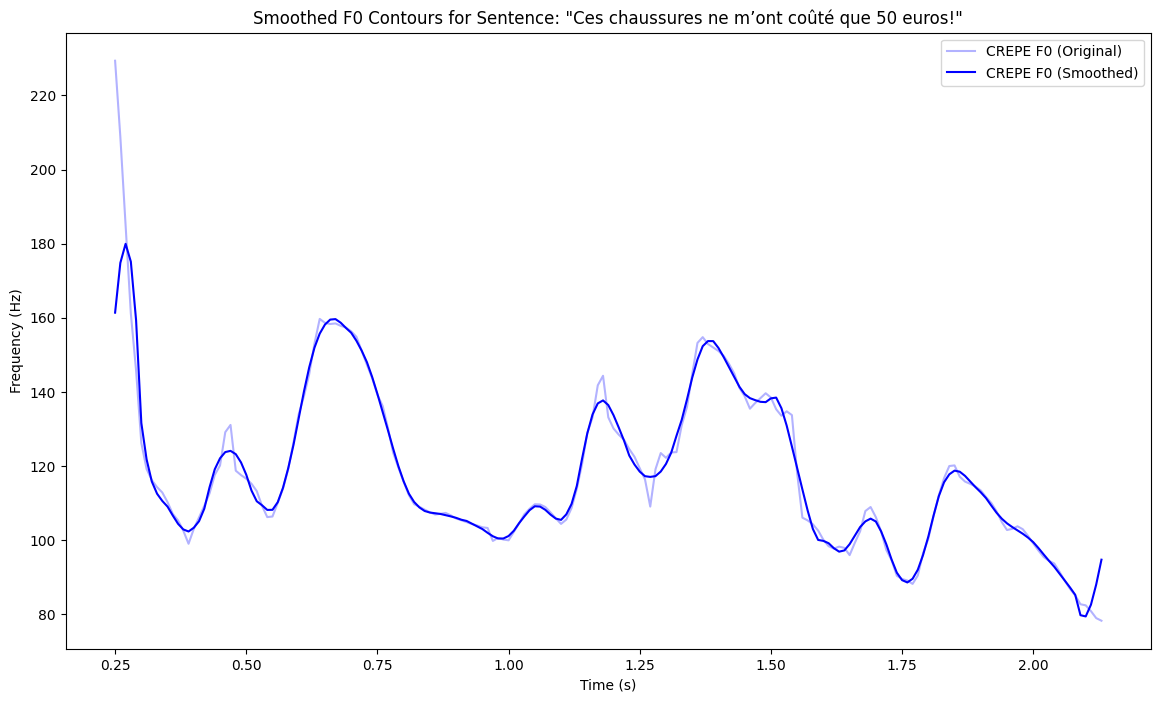

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Function to apply Savitzky-Golay filter
def apply_savgol_filter(df, window_length=11, polyorder=2):
    df['Smoothed_Frequency'] = savgol_filter(df['Frequency'], window_length, polyorder)
    return df



# Apply smoothing
crepe_df = apply_savgol_filter(crepe_df)

# Function to plot smoothed F0 contours
def plot_f0_contour(df, sentence, speaker):
    sentence_df = df[(df['Sentence'] == sentence) & (df['Speaker'] == speaker)]

    plt.figure(figsize=(14, 8))
    plt.plot(sentence_df['time'], sentence_df['Frequency'], label='CREPE F0 (Original)', alpha=0.3, color='blue')
    plt.plot(sentence_df['time'], sentence_df['Smoothed_Frequency'], label='CREPE F0 (Smoothed)', color='blue')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Smoothed F0 Contours for Sentence: "{sentence}"')
    plt.legend()
    plt.show()

# Example usage
sentence = "Ces chaussures ne m’ont coûté que 50 euros!"
speaker = "Speaker9"
plot_f0_contour(crepe_df, sentence, speaker)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset
crepe_df = pd.read_csv('/Users/kiragrudinina/Desktop/Speech/Audios(Segmented)/audios/CREPE_f0_data.csv')

# Assuming the dataset has the columns 'Time', 'Frequency', 'Confidence', 'Word', 'Sentence', 'Mean_F0', 'Speaker', 'Country', 'Gender', 'Age'
# Extract relevant features
features = crepe_df[['Frequency', 'Confidence', 'Mean_F0']]
labels = crepe_df['Sentence']

# Clean the data by dropping rows with missing values
features = features.dropna()
labels = labels[features.index]

# Encode the labels (sentences)
labels_encoded = labels.astype('category').cat.codes

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Save the trained model
import joblib
joblib.dump(clf, 'intonation_model.pkl')


Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.43      0.36      0.39       198
           1       0.43      0.39      0.41       229
           2       0.34      0.40      0.36       386
           3       0.39      0.45      0.42       388
           4       0.45      0.47      0.46       407
           5       0.49      0.51      0.50       360
           6       0.38      0.46      0.42       370
           7       0.37      0.36      0.37       239
           8       0.37      0.37      0.37       323
           9       0.37      0.25      0.30        53
          10       0.42      0.39      0.40       379
          11       0.17      0.14      0.16        35
          12       0.45      0.49      0.47       337
          13       0.49      0.47      0.48       319
          14       0.42      0.35      0.38       265
          15       0.40      0.44      0.42       287
          16       0.45      0.48      0.47       245
          17

['intonation_model.pkl']